# On the Correct Application of the Nonlinear Buckling Method

***

In this notebook we are going to explain a mistake that we have been committing so far when using the nonlinear buckling method of SOL 106, and we are going to show its correct application on the different configurations of the box beam.

* [Introduction](#introduction)
* [Unreinforced box beam](#unreinforced)
* [Box beam reinforced with ribs](#reinforced-ribs)
* [Box beam reinforced with ribs and stiffeners](#reinforced-ribs-stiffeners)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

***

As explained in our [first notebook](01_Buckling_Analysis_of_Euler_Column.ipynb), SOL 106's nonlinear buckling method finds the critical buckling factor $\alpha$ representing the multiplicative factor of the last load increment vector $\boldsymbol{\Delta P}$, that summed to the vector of applied loads of the last iteration $\boldsymbol{P}_n$ gives the critical buckling load $\boldsymbol{P}_{cr}$:

$$\boldsymbol{P}_{cr}=\boldsymbol{P}_n+\alpha\boldsymbol{\Delta P}.$$

So far we have always asked Nastran to perofrm the eigenvalue calculation needed to calculate $\alpha$ using the `EIGRL` card and setting a value of 0 for the field V1, which defines the lower bound of the eigenvalue range of interest. This means that we have constrained Nastran to calculate only positive eigenvalues. However, there is no reason for $\alpha$ not to be negative. In fact, if $\boldsymbol{P}_n$ is beyond $\boldsymbol{P}_{cr}$, the nonlinear buckling method should return a negative $\alpha$, meaning that the critical buckling load is obtained by subtracting a portion of $\boldsymbol{\Delta P}$ from $\boldsymbol{P}_n$.

As a consequence, for a correct application of the nonlinear buckling method we need to leave the field V1 of the `EIGRL` card blank, which allows both positive and negative eigenvalues to be calculated.

Now we are going to perform once again a verification study of the nonlinear buckling method for the three configurations of the box beam that we have considered so far: unreinforced, reinforced with ribs and reinforced with ribs and stiffeners. We remind that the verification of the nonlinear buckling method consists in verifying whether the nonlinear buckling method is able to predict the same critical load predicted by SOL 105 for the linear range of the structural response, that is to say below $P/P_\text{SOL 105}=1$.

## Unreinforced box beam <a name="unreinforced"></a>

***

We consider the same unreinforced box beam analyzed in our [sixth notebook](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb).

![Concentrated tip load.](resources/04_BoxBeamConcentratedLoad.svg "Concentrated tip load.")

 We define the geometry and the material properties, generate the mesh, create the base `BDF` object and apply the concetrated load at the tip constraining the section with a RBE2 element.

In [1]:
from resources import box_beam_utils
import numpy as np
from resources import pynastran_utils

# Define geometry
AR = 9.   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f"""
Box beam dimensions:
- width: {w/1e3:.1f} m
- length: {l/1e3:.1f} m
- height: {h/1e3:.1f} m
- wall thickness: {t:.1f} mm\n""")

# Define material properties
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

# Generate mesh
shell_element_length = 59.9  # from previous mesh convergence study [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_beam(
    width=w, length=l, height=h, element_length=shell_element_length)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

# Creta base BDF object
unreinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(unreinforced_box_beam_bdf.get_bdf_stats())  # print cards of BDF object

# Apply concetrated load at the tip
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = shell_element_length/100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:,1] - l) < tolerance]  # find id of tip section nodes
tip_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam_bdf.add_grid(tip_master_node_id, [w/2, l, 0.])  # add master node of tip section
rbe2_eid = len(unreinforced_box_beam_bdf.elements) + 1
unreinforced_box_beam_bdf.add_rbe2(eid=rbe2_eid, gn=tip_master_node_id, cm='123456', Gmi=tip_nodes_ids)  # add RBE2 to connect master node with outer nodes of tip rib
FORCE_SET_ID = 11
force_direction = [0., 0., 1.]
pynastran_utils.add_uniform_force(
    bdf=unreinforced_box_beam_bdf, nodes_ids=[tip_master_node_id], set_id=FORCE_SET_ID, direction_vector=force_direction)  # add concentrated force


Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 3388

bdf.elements: 0
  CQUAD4   : 3344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we recall the buckling load predicted by SOL 105 and we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude and we keep the other 10 load cases.

In [2]:
sol_105_buckling_load = 1654.  # [N]
applied_load_magnitudes = np.linspace(0, 2*sol_105_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

Applied loads [N]: [ 331.  662.  992. 1323. 1654. 1985. 2316. 2646. 2977. 3308.]


To set up and run our nonlinear analysis, we define the function `run_nonlinear_buckling_method_sweep`. This function sets up the arc-length method for the nonlinear analysis by calling the function `set_up_arc_length_method` from the `pynastran_utils` module, creates one subcase for each applied load in the input array and calls the function `run_nonlinear_buckling_method` from the `pynastran_utils` module. The latter in turn sets up the eigenvalue calculation with the `EIGRL` card leaving the field V1 blank, so that both positive and negative eigenvalues can be calculated, and then it runs the analysis, reads the op2 file and returns the `OP2` object. The same object is also returned by the main function `run_nonlinear_buckling_method_sweep`.

We set the argument `calculate_tangent_stiffness_matrix_eigenvalues=True` of the function `run_nonlinear_buckling_method` to calculate the smallest magnitude eigenvalue of the tangent stiffness matrix for each converged iteration contextually to the nonlinear buckling method. Since the parameters of the `EIGRL` card are used to compute both the eigenvalues of the nonlinear buckling method and the eigenvalues of the tangent stiffness matrix, we also want to verify that the structural stability results obtained in the previous notebooks were not affected by the mistake in setting up the `EIGRL` card.

In [3]:
import os  # import operating system module

# Define name of analysis directory
analysis_directory_name = "13_On_the_Correct_Application_of_the_Nonlinear_Buckling_Method"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Function to set up the nonlinear analysis with the nonlinear buckling methods for increasing applied loads
def run_nonlinear_buckling_method_sweep(bdf_input, load_magnitudes, input_filename, run_flag=True):
    # Set up nonlinear analysis with arc-length method
    pynastran_utils.set_up_arc_length_method(bdf=bdf_input, ninc=100, max_iter=25, conv='PUV', eps_p=1e-3,
                                             eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5,
                                             maxinc=1000)
    # Create the LOAD cards corresponding to the input load magnitudes and the associated subcases
    for i, scale_factor in enumerate(load_magnitudes):
        load_set_id = 21 + i
        bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])
        pynastran_utils.create_static_load_subcase(bdf=bdf_input, subcase_id=i+1, load_set_id=load_set_id)
    # Run analysis with nonlinear buckling method and return OP2 object
    op2 = pynastran_utils.run_nonlinear_buckling_method(bdf=bdf_input, method_set_id=FORCE_SET_ID + 1,
                                                        analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                        calculate_tangent_stiffness_matrix_eigenvalues=True,
                                                        input_name=input_filename, run_flag=run_flag)
    # Return op2 object
    return op2

Let's call the function `run_nonlinear_buckling_method_sweep` for the unreinforced box beam using the applied loads defined earlier.

In [4]:
input_name = 'unreinforced_box_beam'
sol_106_op2 = run_nonlinear_buckling_method_sweep(unreinforced_box_beam_bdf, applied_load_magnitudes, input_name,
                                                  run_flag=False)

Nastran job unreinforced_box_beam.bdf completed
Wall time: 1763.0 s


Now we want to plot the buckling loads predicted by SOL 106, $P_\text{SOL 106}$ and the critical buckling factors, $\alpha$, against the applied load $P$. In order to do this, we define the function `plot_buckling_loads`, which takes as input the path to the f06 file, the `OP2` object, the array of the applied loads and the buckling load predicted by SOL 105. The function reads $P_\text{SOL 106}$ and $\alpha$ from the f06 file and then it plots them against the applied loads. All loads are nondimensionalized with the buckling load predicted by SOL 105.

In [5]:
import matplotlib.pyplot as plt

# Function to plot SOL 106 buckling loads and critical buckling factors against applied loads
def plot_buckling_loads(f06_path, op2_output, applied_loads, linear_buckling_load):
    # Read nonlinear buckling loads and critical buckling factors from f06 file
    nonlinear_buckling_load_vectors, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(
        f06_filepath=f06_path, op2=op2_output)
    nonlinear_buckling_loads = np.linalg.norm(np.sum(nonlinear_buckling_load_vectors[:, :, 0:3], axis=1), axis=1)  # calculate the norm of the nonlinear buckling load vector for each subcase
    # Plot nonlinear buckling loads and critical buckling factors vs applied loads
    _, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
    axs[0].plot(applied_loads/linear_buckling_load, nonlinear_buckling_loads/linear_buckling_load, 'o')  # buckling loads vs applied loads
    axs[1].plot(applied_loads/linear_buckling_load, critical_buckling_factors, 'o')  # critical buckling factors vs applied loads
    # Set plot appearance
    axs[0].set_ylabel('$P_\mathrm{SOL\,106}/P_\mathrm{SOL\,105}$')
    axs[0].grid(visible=True)
    axs[1].set_ylabel('$\\alpha$')
    axs[1].grid(visible=True)
    axs[1].set_xlabel('$P/P_\mathrm{SOL\,105}$')
    plt.show()

Let's call `plot_buckling_loads` and plot the results of our analysis on the unreinforced box beam.

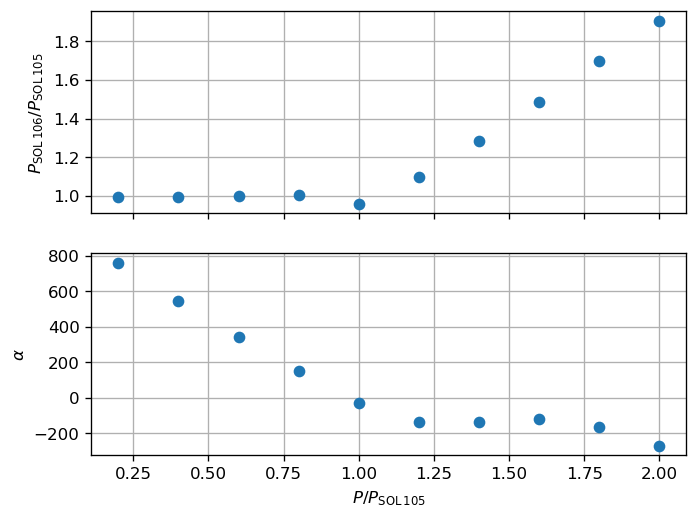

In [6]:
# Set default dpi of figures
plt.rcParams['figure.dpi'] = 120

# Find path to f06 file and plot buckling load results
f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
plot_buckling_loads(f06_filepath, sol_106_op2, applied_load_magnitudes, sol_105_buckling_load)

We observe that while the results for $P/P_\text{SOL 105}<1$ are unchanged with respect to the ones in [notebook 6](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb#verification), the nonlinear buckling loads predicted for $P/P_\text{SOL 105}\geq 1$ are different. For $P/P_\text{SOL 105}=1$, $P_\text{SOL 106}$ is slightly smaller than $P_\text{SOL 105}$, while it was slightly larger in our previous results. In fact, we see that $\alpha$ is negative for such applied load, meaning that the nonlinear buckling method predicts that the critical buckling load has already been exceeded. The negative $\alpha$ persists for all successive applied loads. In general we observe that the magnitude of $\alpha$ is significatively smaller for $P/P_\text{SOL 105}\geq 1$, meaning that the nonlinear buckling method predicts other buckling loads that are closer to each applied load compared to the prediction for $P/P_\text{SOL 105}<1$.

At the same time we observe an increasing nonlinear buckling load for $P/P_\text{SOL 105}\geq 1$ with an evident linear trend, similarly to our previous results. However, do these buckling loads really exist? In other words, does the tangent stiffness matrix ever become singular along the equilibrium path of our box beam?

As mentioned earlier, we have calculated the smallest magnitude eigevalue of the tangent stiffness matrix to verify the structural stability of our box beam. We are going to plot the lowest eigenvalue $\lambda$ at each converged iteartion against the applied load and, for this purpose, we define the function `plot_tangent_stiffness_matrix_eigenvalues`. This takes as input the `OP2` object and the path to the f06 file, reads the load history and the eigenvalues of the tangent stiffness matrix and finally it plots the latter against the former.

In [7]:
def plot_tangent_stiffness_matrix_eigenvalues(op2_output, f06_path, linear_buckling_load):
    # Read load history from OP2 object
    _, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2=op2_output)
    load_history = np.concatenate([applied_loads[subcase_id][:, 2] for subcase_id in applied_loads])  # concatenate load along z from all subcases
    # Read lowest eigenvalues from f06 file
    lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)  # read eigenvalues from f06 files
    # Plot lowest eigenvalues of tangent stiffness matrix vs load history
    _, ax = plt.subplots()
    ax.plot(load_history/linear_buckling_load, lowest_eigenvalues[0, :], 'o')
    plt.xlabel('$P/P_\mathrm{SOL 105}$')
    plt.ylabel('$\lambda$, N/mm')
    plt.grid()
    plt.show()

Let's plot the eigenvalues of the tangent stiffness matrix against the applied loads of our analysis.

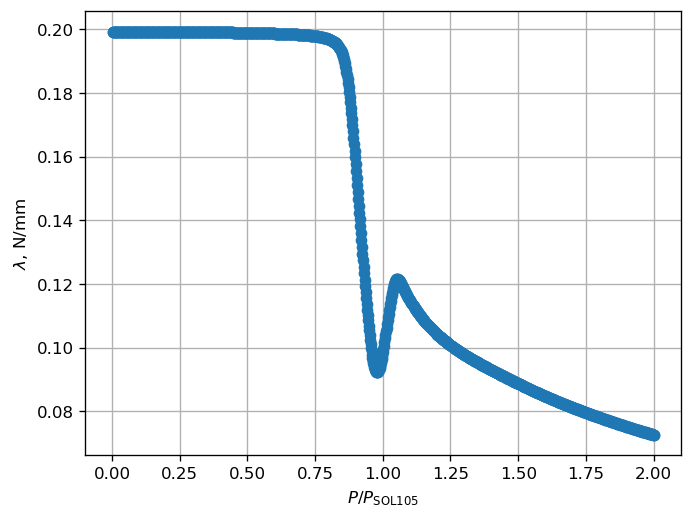

In [8]:
plot_tangent_stiffness_matrix_eigenvalues(sol_106_op2, f06_filepath, sol_105_buckling_load)

We observe the same plot obtained in [notebook 6](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb#tangent-stiffness-matrix), which confirms that the smallest magnitude eigenvalue of the tangent stiffness matrix is always positive for the range investigated loads. As a consequence, we can also confirm that our structure is always in a stable equilibrium.

Furthemore, we can use this plot to intuitively explain why the nonlinear buckling method predicts a buckling load slightly smaller than $P_\text{SOL 105}$ for $P/P_\text{SOL 105}=1$. We need to remind that the nonlinear buckling method performs a linearization using the last two converged solutions of the subcase. If we look at the eigenvalues for $P/P_\text{SOL 105}$ approaching $1$, we can observe that the curve has a negative slope. Intuitively, we can imagine that if we linearized the curve around $P/P_\text{SOL 105}=1$ we would find that lowest eigenvalue would be zero for $P/P_\text{SOL 105}<1$, corresponding to the result calculated by the nonlinear buckling method.

Despite this nice and intuitive explanation, we need to remind that what happens in reality is not so simple. In fact, the nonlinear buckling method solves en eigenvalue problem to find where the tangent stiffness matrix becomes singular based on its linearization, which is different from linearizing the trend of one of its eigenvalues. As a consequence, it might not always be possible to find a correlation between the load calculated by the nonlinear buckling method and the trend of the smallest magnitude eigenvalue of the tangent stiffness matrix.

## Box beam reinforced with ribs <a name="reinforced-ribs"></a>

***

We consider the same box beam reinforced with ribs analyzed in our [eighth notebook](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb). In addition to the geometric and material properties defined earlier, we need to define the number of ribs and their location.

In [9]:
# Define ribs location
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(l/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:.0f}")
print(f"Ribs\' y-coordinate [mm]:")
print(ribs_y_locations)

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


Then we generate the mesh, create the base `BDF` object and apply the concetrated load at the tip, this time connecting the nodes on the edges of the tip rib to the master node at the center with a `RBE3` element.

In [10]:
# Generate mesh
shell_element_length = 59.9  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs(
    ribs_y_coordinates=ribs_y_locations, width=w, height=h, element_length=shell_element_length)
nodes_xyz_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

# Create base BDF object
ribs_reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(ribs_reinforced_box_beam_bdf.get_bdf_stats())

# Define function to apply concetrated load at the tip
def apply_tip_concentrated_load(bdf_input):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = shell_element_length/100  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/100 of elements' length
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) &
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                       comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_uniform_force(
        bdf=bdf_input, nodes_ids=[master_node_id], set_id=FORCE_SET_ID, direction_vector=force_direction)
    # Return id of master node
    return master_node_id

# Apply load
apply_tip_concentrated_load(ribs_reinforced_box_beam_bdf)

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 4514

bdf.elements: 0
  CQUAD4   : 4680

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


4515

Similarly to what we did earlier, we recall the buckling load predicted by SOL 105 and we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude and we keep the other 10 load cases.

In [11]:
sol_105_buckling_load = 3101.  # [N]
applied_load_magnitudes = np.linspace(0, 2*sol_105_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

Applied loads [N]: [ 620. 1240. 1861. 2481. 3101. 3721. 4341. 4962. 5582. 6202.]


Now we run the analysis calling the function `run_nonlinear_buckling_method_sweep` and plot the buckling loads, the critical buckling factors and the eigenvalues of the tangent stiffness matrix.

Nastran job ribs_reinforced_box_beam.bdf completed
Wall time: 2189.0 s


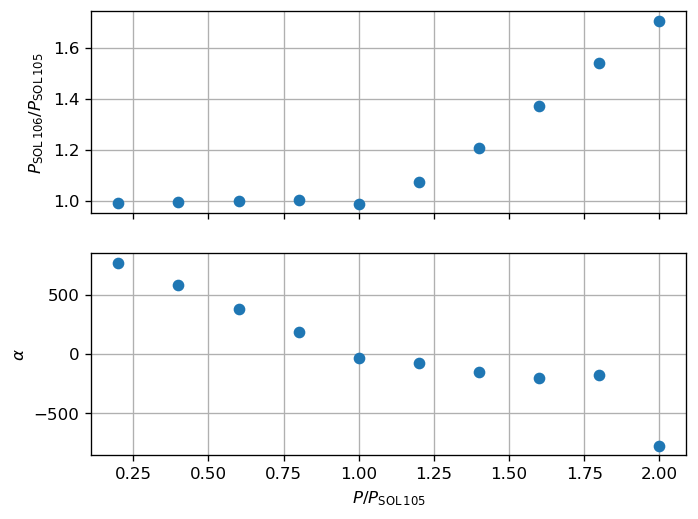

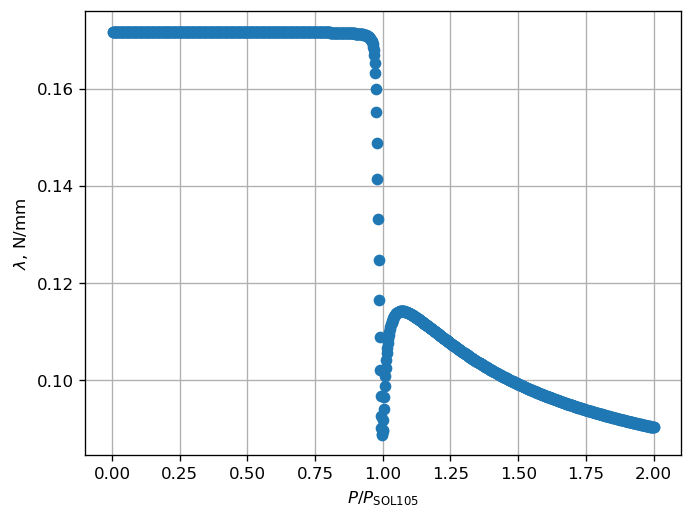

In [12]:
# Run analysis
input_name = 'ribs_reinforced_box_beam'
sol_106_op2 = run_nonlinear_buckling_method_sweep(ribs_reinforced_box_beam_bdf, applied_load_magnitudes, input_name,
                                                  run_flag=False)

# Find path to f06 file and plot buckling load results
f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
plot_buckling_loads(f06_filepath, sol_106_op2, applied_load_magnitudes, sol_105_buckling_load)

# Plot lowest eigenvalues of tangent stiffness matrix vs load history
plot_tangent_stiffness_matrix_eigenvalues(sol_106_op2, f06_filepath, sol_105_buckling_load)

Also in this case we observe that the nonlinear buckling method predicts the same buckling load as SOL 105 for $P/P_\text{SOL 105}<1$, a slightly smaller buckling load than SOL 105 for $P/P_\text{SOL 105}=1$ and finally increasing buckling loads for $P/P_\text{SOL 105}>1$, again with a linear trend. The buckling factors are large and decreasing for $P/P_\text{SOL 105}<1$ and then negative with a smaller magnitude for $P/P_\text{SOL 105}\geq 1$, except for the last factor. The smallest magnitude eigenvalue of the tangent stiffness matrix results in the same behavior as in our [previous notebook](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-buckling-method-verification): it is constant up to almost $P/P_\text{SOL 105}=1$, it undergoes an abrupt drop, it recovers and then it gradually decreases again. However, the value is always positive, meaning that our box beam never encounters a critical point along its equilibrium path.

## Box beam reinforced with ribs and stiffeners <a name="reinforced-ribs-stiffeners"></a>

***

Now we consider the same box beam reinforced with ribs and stiffeners analyzed in our [last notebook](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb). We define the number of stiffeners, their location and their height. Then we generate the mesh, create the base `BDF` object and we apply the concentrated tip load in the same way as done for the box beam reinforced with ribs only.

In [13]:
# Define location and height of stiffeners
stiffeners_spacing = ribs_spacing/1.4
no_stiffeners = int(np.ceil(w/stiffeners_spacing)) - 1
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]
stiffeners_height = h/10
print(f"Number of stiffeners: {no_stiffeners:d}")
print(f"Stiffeners x-coordinate [mm]:")
print(stiffeners_x_locations)
print(f"Stiffeners height: {stiffeners_height:.0f} mm")

# Generate mesh
shell_element_length = 47.0  # from previous mesh convergence study [mm]
box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=shell_element_length)
nodes_xyz_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

# Create base BDF object
ribs_stiffeners_reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(ribs_stiffeners_reinforced_box_beam_bdf.get_bdf_stats())

# Apply load
apply_tip_concentrated_load(ribs_stiffeners_reinforced_box_beam_bdf)

Number of stiffeners: 2
Stiffeners x-coordinate [mm]:
[333. 667.]
Stiffeners height: 20 mm
---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 8562

bdf.elements: 0
  CQUAD4   : 8784

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


8563

We recall the buckling load predicted by SOL 105, define the applied loads, run our analysis and produce our plots.

Applied loads [N]: [ 1685.  3370.  5054.  6739.  8424. 10109. 11794. 13478. 15163. 16848.]
Nastran job ribs_stiffeners_reinforced_box_beam.bdf completed
Wall time: 4765.0 s


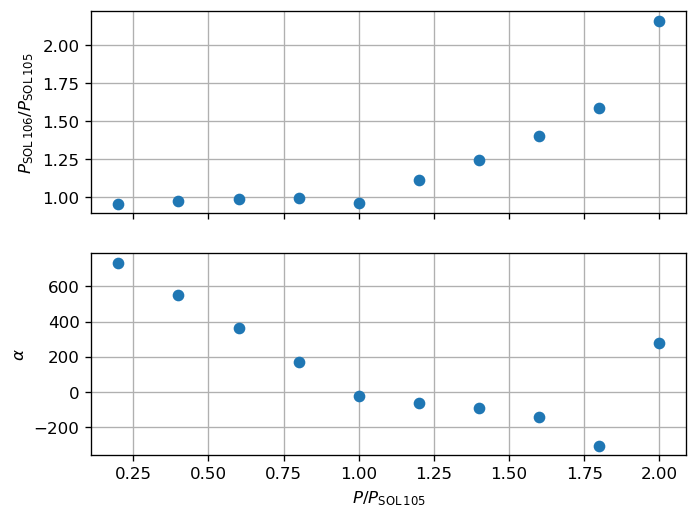

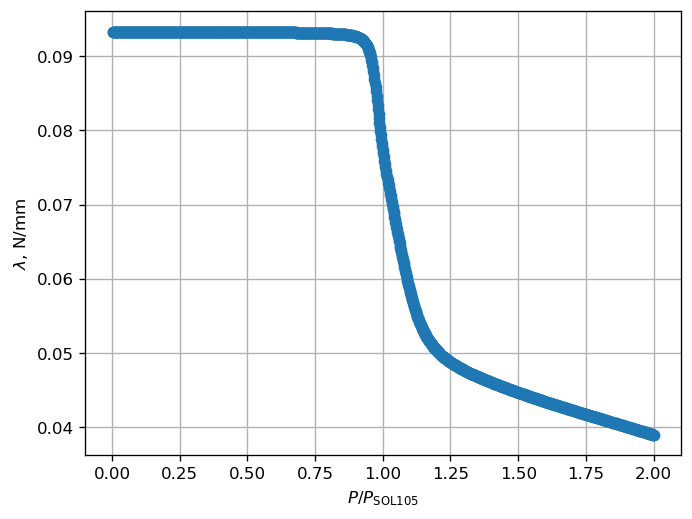

In [14]:
# Define applied loads
sol_105_buckling_load = 8424.  # [N]
applied_load_magnitudes = np.linspace(0, 2*sol_105_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

# Run analysis
input_name = 'ribs_stiffeners_reinforced_box_beam'
sol_106_op2 = run_nonlinear_buckling_method_sweep(ribs_stiffeners_reinforced_box_beam_bdf, applied_load_magnitudes,
                                                  input_name, run_flag=False)

# Find path to f06 file and plot buckling load results
f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
plot_buckling_loads(f06_filepath, sol_106_op2, applied_load_magnitudes, sol_105_buckling_load)

# Plot lowest eigenvalues of tangent stiffness matrix vs load history
plot_tangent_stiffness_matrix_eigenvalues(sol_106_op2, f06_filepath, sol_105_buckling_load)

Once again, we find that the nonlinear buckling method predicts the same buckling load as SOL 105 for $P/P_\text{SOL 105}<1$, a slightly smaller buckling load than SOL 105 for $P/P_\text{SOL 105}=1$ and finally increasing buckling loads for $P/P_\text{SOL 105}>1$. This time the linear trend seems to be broken for the largest applied load. This result suggests that we should not always expect to find a relation between buckling loads and applied loads and that when we observe it, it is probably fortuitous.

Similarly to the previous cases, the buckling factors are large and decreasing for $P/P_\text{SOL 105}<1$ and negative with a smaller magnitude for $P/P_\text{SOL 105}\geq 1$, with the exception of the largest applied load that results in a positive critical buckling factor. This result suggests that the succession of the values of $\alpha$ for $P/P_\text{SOL 105}\geq 1$ is case-dependent and that we should not expect to observe any repetitive behavior.

Finally, the smallest magnitude eigenvalue of the tangent stiffness matrix is the same as in our [previous notebook](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#nonlinear-buckling-method-verification): it is constant up to an applied load slightly lower than $P/P_\text{SOL 105}=1$, it undergoes an abrupt decrease and finally the rate of decrease becomes more gradual around $P/P_\text{SOL 105}=1.25$. The value never reaches 0 for the load range investigated here, meaning that also the box beam reinforced with ribs and stiffeners never encounters a critical or unstable point along its equilibrium path.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have explained a mistake that we did in our previous notebooks when applying the nonlinear buckling method and we have rerun the nonlinear buckling analysis for all the box beam configurations investigated so far. We found some small differences in the results of the nonlinear buckling method, which however did not change the validity of our hypothesis regarding the bifurcation break of our box beam. In fact, after the correction of our eigenvalue calculation settings, we have found the lowest eigenvalues of the tangent stiffness matrix to have the same trends as in our results, for all the box beam configurations. Namely, we always observed positive values of the lowest eigenvalue, meaning that the structure does never encounter a critical point along its equilibrium path, similarly to what happens along the natural path of the broken supercritical pitchfork of the imperfect Euler's column.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have explained a mistake that we did in our previous notebooks when applying the nonlinear buckling method and we have rerun the nonlinear buckling analysis for all the box beam configurations investigated so far. We found some small differences in the results of the nonlinear buckling method, which however did not change the validity of our hypothesis regarding the bifurcation break of our box beam. In fact, after the correction of our eigenvalue calculation settings, we have found the lowest eigenvalues of the tangent stiffness matrix to have the same trends as in our results, for all the box beam configurations. Namely, we always observed positive values of the lowest eigenvalue, meaning that the structure does never encounter a critical point along its equilibrium path, similarly to what happens along the natural path of the broken supercritical pitchfork of the imperfect Euler's column.